In [1]:
#Importing packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import datetime
import seaborn as sns
import math
import xgboost as xgb
import joblib

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_squared_log_error
#!pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot, residuals_plot, prediction_error

import requests # library to handle requests

print("Libraries imported!")

Libraries imported!


In [2]:
df = pd.read_csv('cleaned_full_data.csv', index_col=0)
print(df.shape)
df.head()

(122351, 18)


,Name,Mileage,Address,Rating,Fuel Type,City MPG,Highway MPG,Drivetrain,Engine,Exterior Color,Interior Color,Transmission,Num_ent_features,Num_safe_features,Price,Model Year,Car Model,Make
0,2020 BMW 330 i xDrive,24371,"Brooklyn, NY 11203",3.5,Gasoline,25.0,34.0,AWD,2.0L,Black,Black,Automatic,2.0,5.0,29893,2020,330,BMW
2,2018 Toyota RAV4 Limited,11863,"Brooklyn, NY 11210",3.5,Gasoline,22.0,28.0,AWD,2.5L,Black,Black,Automatic,2.0,6.0,26225,2018,RAV4,Toyota
7,2017 INFINITI Q60 3.0T Premium,10422,"Woodside, NY 11377",1.1,Gasoline,19.0,27.0,AWD,3.0L,Black,Graphite,Automatic,2.0,3.0,25995,2017,Q60,INFINITI
8,Certified 2017 Mercedes-Benz GLS 450 Base 4MATIC,24351,"Long Island City, NY 11101",4.8,Gasoline,19.0,22.0,AWD,3.0L,Gray,Black,Automatic,3.0,4.0,45594,2017,GLS,Mercedes-Benz
10,2019 Kia Optima LX,23152,"Woodside, NY 11377",3.9,Gasoline,24.0,33.0,FWD,2.4L,Black,Black,Automatic,2.0,7.0,13399,2019,Optima,Kia


In [3]:
df.describe()

,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Price,Model Year
count,122351.000000,122351.000000,122351.000000,122351.000000,122351.000000,122351.000000,122351.000000,122351.000000
mean,36404.493294,4.325117,22.385996,30.466984,1.858211,3.763721,29760.096166,2017.897451
std,31736.593636,0.677057,10.895412,21.348057,0.714725,1.356618,13230.070446,2.380640
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1500.000000,2001.000000
25%,14752.500000,4.200000,18.000000,25.000000,1.000000,3.000000,19998.000000,2017.000000
50%,29703.000000,4.500000,21.000000,28.000000,2.000000,3.000000,27480.000000,2018.000000
75%,47414.500000,4.800000,24.000000,32.000000,2.000000,5.000000,36988.000000,2020.000000
max,200000.000000,5.000000,204.000000,414.000000,4.000000,7.000000,87488.000000,2022.000000


In [4]:
y_df = df.loc[:,'Price']
X_df = df[['Make', 'Car Model', 'Model Year', 'Mileage', 'Rating', 'Fuel Type', 'City MPG', 'Highway MPG', 'Drivetrain', 'Engine', 'Exterior Color',
        'Interior Color', 'Transmission', 'Num_ent_features', 'Num_safe_features']]

In [5]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122351 entries, 0 to 187167
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Make               122351 non-null  object 
 1   Car Model          122351 non-null  object 
 2   Model Year         122351 non-null  int64  
 3   Mileage            122351 non-null  int64  
 4   Rating             122351 non-null  float64
 5   Fuel Type          122351 non-null  object 
 6   City MPG           122351 non-null  float64
 7   Highway MPG        122351 non-null  float64
 8   Drivetrain         122351 non-null  object 
 9   Engine             122351 non-null  object 
 10  Exterior Color     122351 non-null  object 
 11  Interior Color     122351 non-null  object 
 12  Transmission       122351 non-null  object 
 13  Num_ent_features   122351 non-null  float64
 14  Num_safe_features  122351 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 14

In [6]:
df = df[['Make', 'Car Model', 'Model Year', 'Mileage', 'Address', 'Rating', 'Fuel Type', 'City MPG', 'Highway MPG', 'Drivetrain', 'Engine', 'Exterior Color',
        'Interior Color', 'Transmission', 'Num_ent_features', 'Num_safe_features', 'Price']]

In [7]:
numeric_subset = ['Model Year', 'Mileage', 'Rating', 'City MPG', 'Highway MPG', 'Num_ent_features', 'Num_safe_features', 'Price']

In [8]:
sub_df = df.loc[:,numeric_subset]
sub_df.head()

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Price
0,2020,24371,3.5,25.0,34.0,2.0,5.0,29893
2,2018,11863,3.5,22.0,28.0,2.0,6.0,26225
7,2017,10422,1.1,19.0,27.0,2.0,3.0,25995
8,2017,24351,4.8,19.0,22.0,3.0,4.0,45594
10,2019,23152,3.9,24.0,33.0,2.0,7.0,13399


In [9]:
sub_df.corr()

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Price
Model Year,1.000000,-0.770438,0.022775,0.067205,0.020442,0.275614,0.461701,0.402622
Mileage,-0.770438,1.000000,-0.037864,-0.108726,-0.045039,-0.233395,-0.394132,-0.399986
Rating,0.022775,-0.037864,1.000000,0.004771,0.003710,0.029107,0.028517,0.039542
City MPG,0.067205,-0.108726,0.004771,1.000000,0.406904,-0.029380,0.151478,-0.196576
Highway MPG,0.020442,-0.045039,0.003710,0.406904,1.000000,-0.002234,0.058156,-0.147112
Num_ent_features,0.275614,-0.233395,0.029107,-0.029380,-0.002234,1.000000,0.152295,0.314008
Num_safe_features,0.461701,-0.394132,0.028517,0.151478,0.058156,0.152295,1.000000,0.069817
Price,0.402622,-0.399986,0.039542,-0.196576,-0.147112,0.314008,0.069817,1.000000


Text(0.5, 1.0, "Correlations between dataset's numerical features")

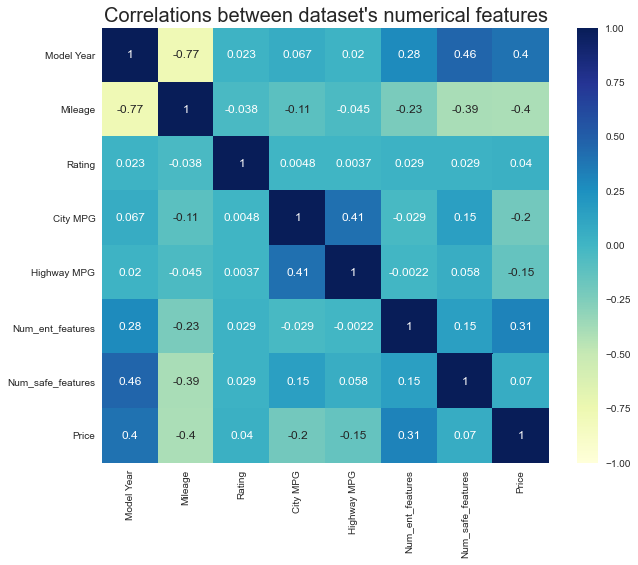

In [10]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(sub_df.corr(), cmap="YlGnBu", annot=True, vmin=-1, vmax=1)
plt.title("Correlations between dataset's numerical features", fontsize=20)

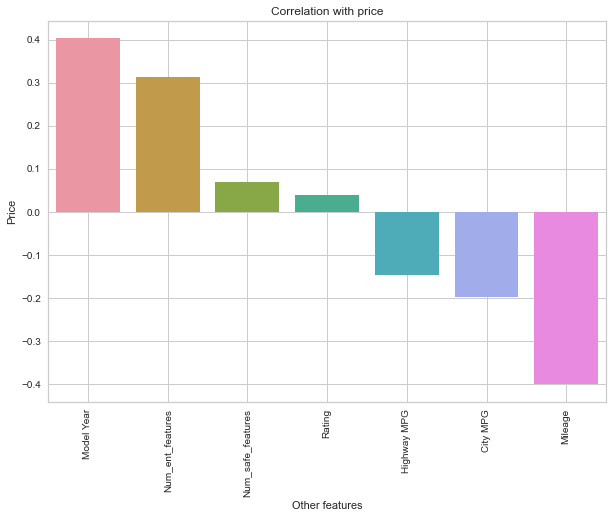

In [11]:
# Sorting the data and reset the index
df_corr = sub_df.corr().iloc[:,-1].sort_values(ascending=False).reset_index()

df_corr = df_corr[df_corr["Price"] < 1]  # Eliminate the 'price' in the x-axis

plt.figure(figsize=(10,7))
sns.barplot(x = "index", y = "Price", data = df_corr);
plt.xlabel("Other features")
plt.xticks(rotation = 90)
plt.title("Correlation with price");
plt.grid(True)
sns.set_style("dark")
plt.savefig('figures/corr_bar.png')

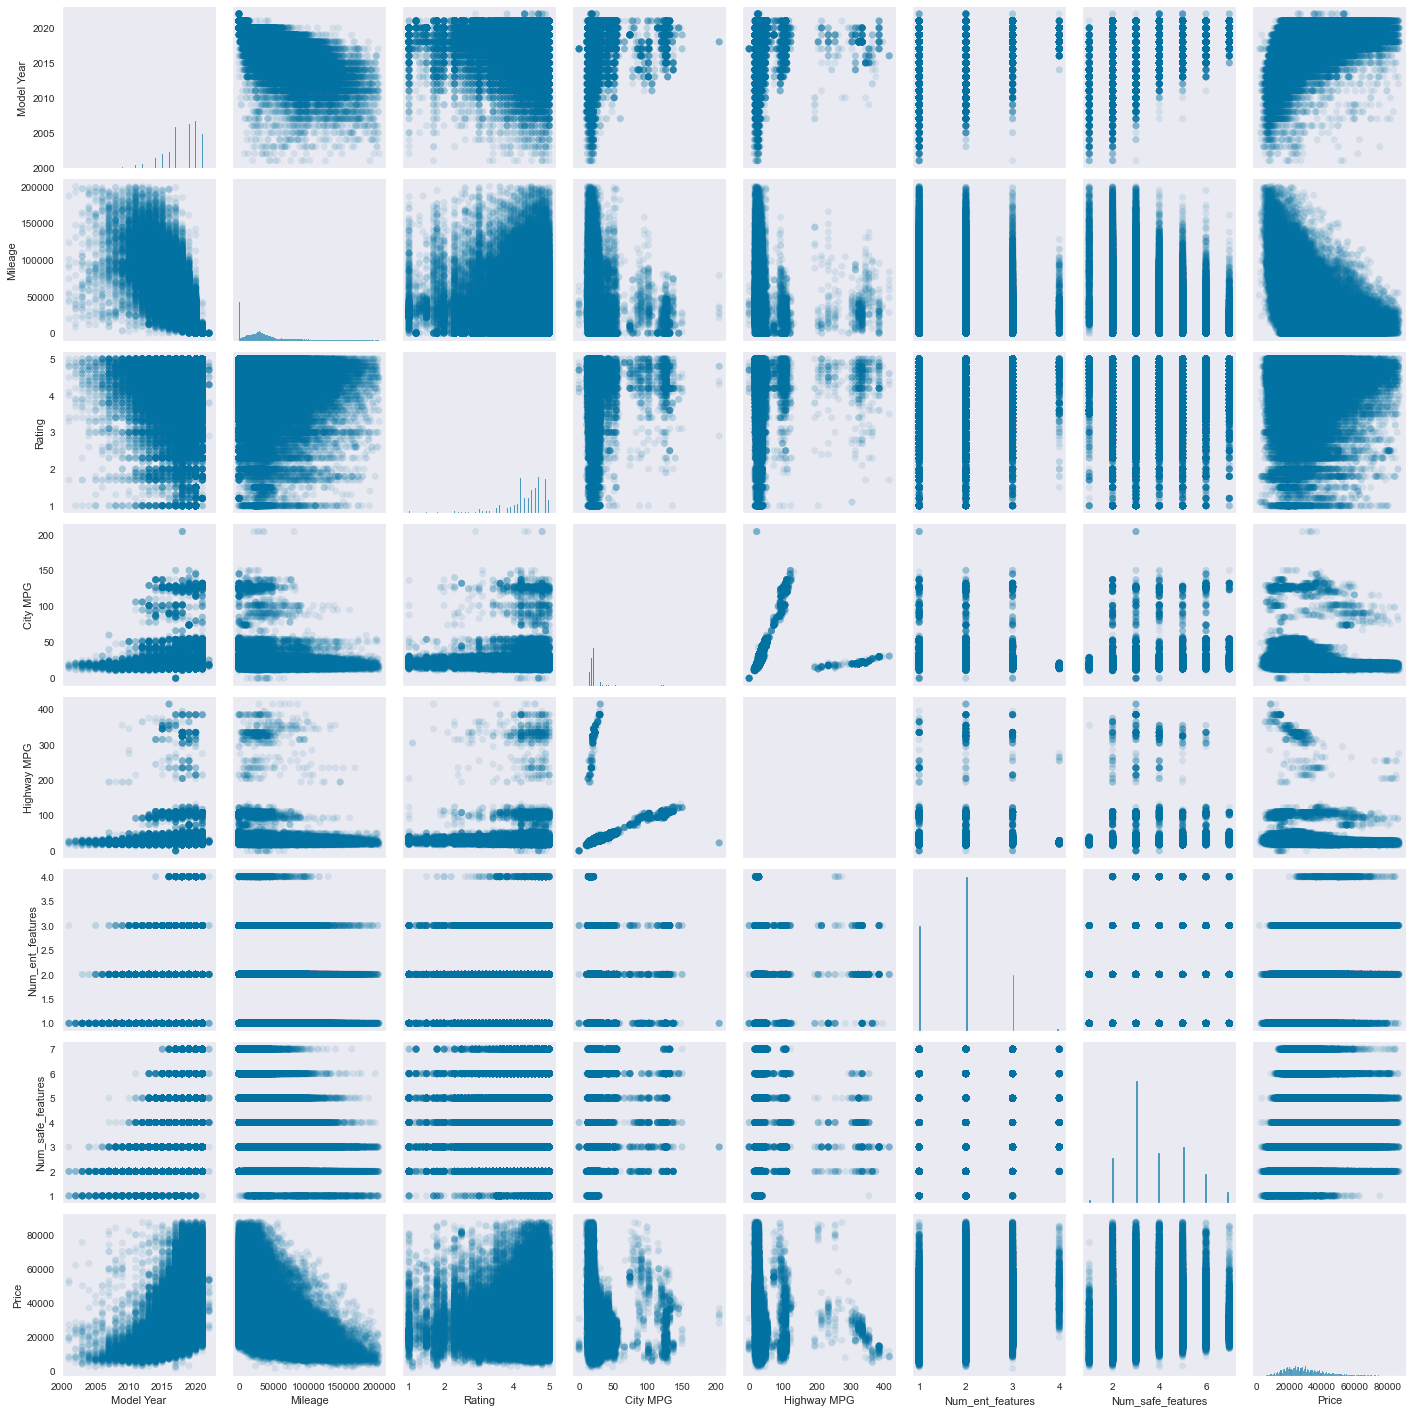

In [12]:
sns.pairplot(sub_df, plot_kws=dict(alpha=.1, edgecolor='none'))

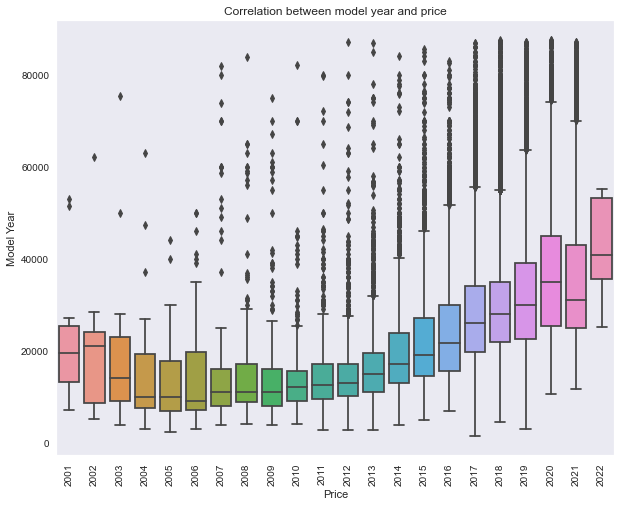

In [107]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Model Year',y='Price', data=sub_df)
plt.title('Correlation between model year and price')
plt.ylabel('Model Year')
plt.xlabel('Price')
plt.xticks(rotation=90)
plt.savefig('figures/botplot_year_price.png');

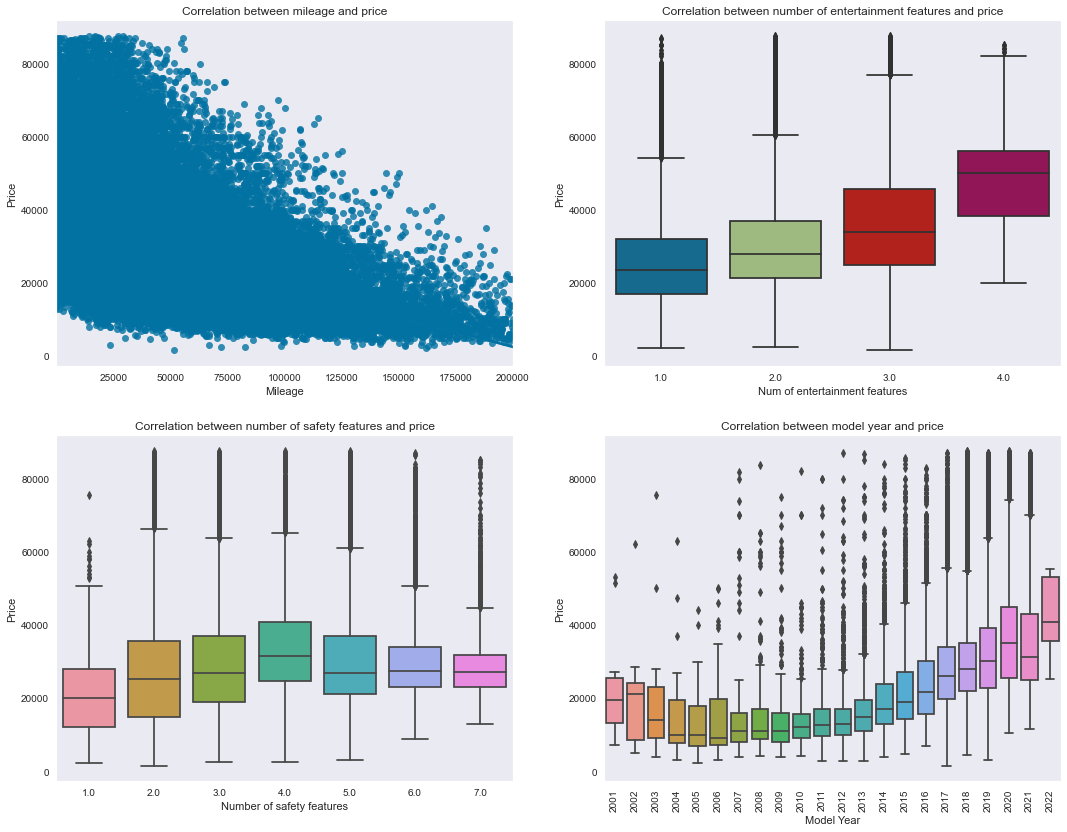

In [13]:
fig = plt.figure(figsize = (18,14)) # create figure

ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)  
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

# Subplot 1:
sns.regplot(x='Mileage',y='Price',data=sub_df, ax=ax0)
ax0.set_title('Correlation between mileage and price')
ax0.set_xlabel('Mileage')
ax0.set_ylabel('Price')


# Subplot 2:
sns.boxplot(x='Num_ent_features',y='Price',data=sub_df, ax=ax1)
ax1.set_title('Correlation between number of entertainment features and price')
ax1.set_xlabel('Num of entertainment features')
ax1.set_ylabel('Price')

#Subplot 3:
sns.boxplot(x='Num_safe_features',y='Price',data=sub_df, ax=ax2)
ax2.set_title('Correlation between number of safety features and price')
ax2.set_xlabel('Number of safety features')
ax2.set_ylabel('Price')

#Subplot 4:
sns.boxplot(x='Model Year',y='Price', data=sub_df, ax=ax3)
ax3.set_title('Correlation between model year and price')
ax3.set_xlabel('Model Year')
ax3.set_ylabel('Price')
plt.xticks(rotation=90)

plt.show()

In [14]:
X_df = sub_df[['Model Year', 'Mileage', 'Rating', 'City MPG', 'Highway MPG', 'Num_ent_features', 'Num_safe_features']]
y_df = sub_df['Price']

In [15]:
X_boost = X_df.copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(X_boost, y_df, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
print(r2_score(y_val, model.predict(X_val)))
print(math.sqrt(mean_squared_error(y_val, model.predict(X_val))))

0.7322923478618113
6870.565127711549


In [99]:
def XGBoost_train_test(X, y):
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    
    print('R^2 for train set: {}'.format(r2_score(y_train, model.predict(X_train))))
    print('R^2 for val set: {}'.format(r2_score(y_val, model.predict(X_val))))
    print('R^2 for test set: {}'.format(r2_score(y_test, model.predict(X_test))))
    print(math.sqrt(mean_squared_error(y_val, model.predict(X_val))))

In [18]:
XGBoost_train_test(X_df, y_df)

R^2 for val set: 0.7322923478618113
R^2 for test set: 0.7288583758238683
6870.565127711549


In [100]:
XGBoost_train_test(sub_df.drop('Price', axis = 1), sub_df[['Price']])

R^2 for train set: 0.7625655324244883
R^2 for val set: 0.7322923478618113
R^2 for test set: 0.7288583758238683
6870.565127711549


### Train / Val / Test models

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [20]:
#Simple Linear Model

lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_train,y_train))
print(lm.score(X_train_val, y_train_val))

0.2968107628850756
0.2973853168930156


R^2 is low on both train and val sets, so the model is severely underfit. Let's do polynomial.

In [21]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
print(lr_poly.score(X_train_poly,y_train))

# Score on validation set
print(lr_poly.score(X_val_poly, y_val))

0.4765374412255855
0.4702617923177477


OK, that's a bit better, but still underfit. Let's work on categorial features.

In [22]:
X_df_2 = X_df.copy()
X_df_2['Make'] = df['Make']
X_df_2 = pd.get_dummies(X_df_2, drop_first=True)
X_df_2.head()

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,...,Make_Porsche,Make_RAM,Make_Saturn,Make_Scion,Make_Subaru,Make_Tesla,Make_Toyota,Make_Volkswagen,Make_Volvo,Make_smart
0,2020,24371,3.5,25.0,34.0,2.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,11863,3.5,22.0,28.0,2.0,6.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,2017,10422,1.1,19.0,27.0,2.0,3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2017,24351,4.8,19.0,22.0,3.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2019,23152,3.9,24.0,33.0,2.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df_2, y_df, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(lm.score(X_train,y_train))
print(lm.score(X_train_val, y_train_val))

0.502833107554211
0.5046552735421197


In [24]:
XGBoost_train_test(X_df_2, y_df)

R^2 for val set: 0.8726204620609317
R^2 for test set: 0.8702536446918147
4739.274924038011


In [25]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
print(lr_poly.score(X_train_poly,y_train))

# Score on validation set
print(lr_poly.score(X_val_poly, y_val))

0.7053363833745397
0.695256828891875


Model is doing a bit overfitting on Polynomial degree 2. Let's regularize it using lasso and ridge

In [26]:
# StandardScaler() our data
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Apply the same scaler to val set
X_val_poly_scaled = scaler.transform(X_val_poly)

# Fit a LASSO model using polynomial features
lasso = LassoCV()
lasso.fit(X_train_poly_scaled,y_train)
print(lasso.score(X_train_poly_scaled,y_train))

# Score on validation set
print(lasso.score(X_val_poly_scaled, y_val))

0.6925930197577085
0.6931452460661829


So, it gets better, but the R^2 is still low. Let's work with a different categorical variable.

In [27]:
X_fuel = X_df.copy()
X_fuel['Fuel Type'] = df['Fuel Type']
X_fuel = pd.get_dummies(X_fuel, drop_first=True)
X_fuel

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Fuel Type_E85 Flex Fuel,Fuel Type_Electric,Fuel Type_Gasoline,Fuel Type_Hybrid
0,2020,24371,3.5,25.0,34.0,2.0,5.0,0,0,1,0
2,2018,11863,3.5,22.0,28.0,2.0,6.0,0,0,1,0
7,2017,10422,1.1,19.0,27.0,2.0,3.0,0,0,1,0
8,2017,24351,4.8,19.0,22.0,3.0,4.0,0,0,1,0
10,2019,23152,3.9,24.0,33.0,2.0,7.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
187150,2017,34911,3.2,21.0,28.0,3.0,3.0,0,0,0,1
187152,2017,46105,3.4,19.0,26.0,2.0,4.0,0,0,1,0
187159,2017,51170,4.7,17.0,24.0,3.0,2.0,0,0,1,0
187165,2016,127717,4.8,21.0,28.0,1.0,3.0,0,0,1,0


In [28]:
def train_validate_test(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

    lm = LinearRegression()
    lm.fit(X_train,y_train)

    print('LM R^2 train score: {}'.format(lm.score(X_train,y_train)))
    print('LM R^2 val score: {}'.format(lm.score(X_train_val, y_train_val)))

    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)

    # Apply polynomial transformation to val set
    X_val_poly = poly.transform(X_val)

    # Fit a model using polynomial features
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly,y_train)
    print('Poly R^2 train score: {}'.format(lr_poly.score(X_train_poly,y_train)))

    # Score on validation set
    print('Poly R^2 test score: {}'.format(lr_poly.score(X_val_poly, y_val)))

    # StandardScaler() our data
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)

    # Apply the same scaler to val set
    X_val_poly_scaled = scaler.transform(X_val_poly)

    # Fit a LASSO model using polynomial features
    lasso = LassoCV()
    lasso.fit(X_train_poly_scaled,y_train)
    print('Lasso poly R^2 train score: {}'.format(lasso.score(X_train_poly_scaled,y_train)))

    # Score on validation set
    print('Lasso poly R^2 test score: {}'.format(lasso.score(X_val_poly_scaled, y_val)))
    
    #Fit a ridge model using polynomial features
    ridge = RidgeCV()
    ridge.fit(X_train_poly_scaled, y_train)
    print('Ridge poly R^2 train score: {}'.format(ridge.score(X_train_poly_scaled, y_train)))
    print('Ridge poly R^2 test score: {}'.format(ridge.score(X_val_poly_scaled, y_val)))

In [29]:
train_validate_test(X_fuel, y_df)

LM R^2 train score: 0.46735785652739026
LM R^2 val score: 0.4676131615750784
Poly R^2 train score: 0.6186559141536097
Poly R^2 test score: 0.5911829779330793
Lasso poly R^2 train score: 0.6146651319468418
Lasso poly R^2 test score: 0.5887728218690407
Ridge poly R^2 train score: 0.6167690463710032
Ridge poly R^2 test score: 0.5892886980732956


In [92]:
sub_df[['Price']]

,Price
0,29893
2,26225
7,25995
8,45594
10,13399
...,...
187150,17995
187152,44977
187159,32291
187165,15495


The results are not very promising, let's try other models on 3 datasets above

In [101]:

def RF_GBR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

    rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("Random Forest Regression R^2 on train set:", r2_score(y_train, rf.predict(X_train)))
    print("Random Forest Regression R^2 on test set:", r2_score(y_test, y_pred))

    gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    print("Gradient Boosted Regression R^2 on train set:", r2_score(y_train, gbm.predict(X_train)))
    print("Gradient Boosted Regression R^2 on test set:", r2_score(y_test, y_pred))


In [102]:
RF_GBR(sub_df.drop('Price', axis = 1), sub_df[['Price']])

Random Forest Regression R^2 on train set: 0.5805889442914047
Random Forest Regression R^2 on test set: 0.5774590849670809
Gradient Boosted Regression R^2 on train set: 0.6107605685397908
Gradient Boosted Regression R^2 on test set: 0.6054963767603769


In [32]:
RF_GBR(X_df_2, y_df)

Random Forest Regression: 0.3650697171113253
Gradient Boosted Regression: 0.6726851869807458


In [33]:
RF_GBR(X_fuel, y_df)

Random Forest Regression: 0.5694190300955846
Gradient Boosted Regression: 0.6374398117539039


It gets better, but not so much. We probably need to fine tune the hyperparameters to get better results. Before consider doing that, let's engineer more features from the original dataset

Let's dummify the entire dataset

In [35]:
X_df[['Car Model', 'Make', 'Fuel Type', 'Drivetrain', 'Engine', 'Exterior Color', 'Interior Color', 'Transmission']] = df[['Car Model', 'Make', 'Fuel Type', 'Drivetrain', 'Engine', 'Exterior Color', 'Interior Color', 'Transmission']]

cars = pd.get_dummies(X_df, drop_first=True)

print(cars.shape)
cars.head()

(122351, 584)


,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Car Model_128,Car Model_1500,Car Model_1LT,...,Exterior Color_Other,Exterior Color_Red,Exterior Color_Silver,Exterior Color_White,Interior Color_Charcoal,Interior Color_Ebony,Interior Color_Graphite,Interior Color_Gray,Interior Color_Other,Transmission_Manual
0,2020,24371,3.5,25.0,34.0,2.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,11863,3.5,22.0,28.0,2.0,6.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2017,10422,1.1,19.0,27.0,2.0,3.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,2017,24351,4.8,19.0,22.0,3.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2019,23152,3.9,24.0,33.0,2.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
cars

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Car Model_128,Car Model_1500,Car Model_1LT,...,Exterior Color_Other,Exterior Color_Red,Exterior Color_Silver,Exterior Color_White,Interior Color_Charcoal,Interior Color_Ebony,Interior Color_Graphite,Interior Color_Gray,Interior Color_Other,Transmission_Manual
0,2020,24371,3.5,25.0,34.0,2.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,11863,3.5,22.0,28.0,2.0,6.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2017,10422,1.1,19.0,27.0,2.0,3.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,2017,24351,4.8,19.0,22.0,3.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2019,23152,3.9,24.0,33.0,2.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187150,2017,34911,3.2,21.0,28.0,3.0,3.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
187152,2017,46105,3.4,19.0,26.0,2.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187159,2017,51170,4.7,17.0,24.0,3.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187165,2016,127717,4.8,21.0,28.0,1.0,3.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [36]:
X_train_val, X_test, y_train_val, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(lm.score(X_train,y_train))
print(lm.score(X_train_val, y_train_val))

0.8707134667685096
0.8693184253615753


Much better!!! <br />
How about our badass XGBoost?

In [109]:
XGBoost_train_test(cars, y_df)

R^2 for train set: 0.9319299678506562
R^2 for val set: 0.9202696307240525
R^2 for test set: 0.920119516405717
3749.5051627615626


WOW! Impressive!!!

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaler to val set
X_val_scaled = scaler.transform(X_val)

# Fit a LASSO model using polynomial features
lasso = LassoCV()
lasso.fit(X_train_scaled,y_train)
lasso.score(X_train_scaled,y_train)

0.8700981599344733

In [39]:
# Score on validation set
lasso.score(X_val_scaled, y_val)

0.8645760012344371

In [40]:
ridge = RidgeCV()
ridge.fit(X_train_scaled,y_train)
ridge.score(X_train_scaled,y_train)

0.8706894657542674

In [41]:
# Score on validation set
ridge.score(X_val_scaled, y_val)

0.8650823075497515

Looks like both Lasso and Ridge models don't work any better than our simple Linear Regression model. <br/>
Next, let's do K-fold CV to validate our results.

## K-fold CV

In [42]:
X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

In [43]:
from sklearn.model_selection import cross_val_score, KFold
lm = LinearRegression()

cross_val_score(lm, cars, y_df, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.85868035, 0.86341242, 0.87013704, 0.86287097, 0.86292522])

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, cars, y_df, cv=kf, scoring='r2')

array([0.86899315, 0.86690581, 0.87182616, 0.86387704, 0.8670687 ])

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, cars, y_df, cv=kf, scoring='r2')))

0.8677635611285595


In [57]:
xgb_reg = xgb.XGBRegressor()

cross_val_score(xgb_reg, cars, y_df, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.91495915, 0.91889427, 0.92494716, 0.91252905, 0.91876943])

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(xgb_reg, cars, y_df, cv=kf, scoring='r2')

array([0.92235991, 0.92115462, 0.92693753, 0.92062116, 0.92385053])

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(xgb_reg, cars, y_df, cv=kf, scoring='r2')))

0.9235128486158336


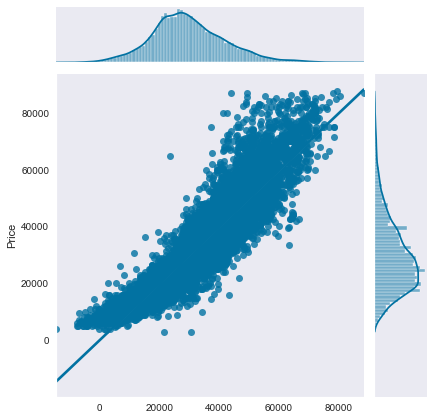

In [46]:
X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

#Train the model on the whole train set
lm = LinearRegression()
lm.fit(X_train, y_train)

#Run the model on the entire set

y_pred = lm.predict(X_test)

# kind must be one of ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']`
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.savefig('figures/joint_linear.png')
plt.show()

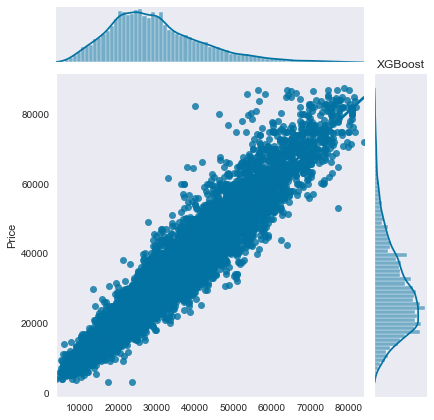

In [47]:
X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

#Train the model on the whole train set
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

# kind must be one of ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']`
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost')
plt.savefig('figures/joint_xgboost.png')
plt.show()

In [48]:
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
#Run the model on the entire set
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(pd.get_dummies(X_df, drop_first=True), y_df)

joblib.dump(xgb_reg, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [50]:
print(f'Linear Regression R^2 score on train set: {lm.score(X_train, y_train):.4f}')
print(f'Linear Regression R^2 score on test set: {lm.score(X_test, y_test):.4f}')

y_pred = lm.predict(X_test)
#Display some of the metrics:

print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))

Linear Regression R^2 score on train set: 0.8698
Linear Regression R^2 score on test set: 0.8682
Mean Absolute Error: 3354.0213662280034
Mean Squared Error: 22924016.979810514
Root Mean Square Error (RMSE): 4787.903192401713


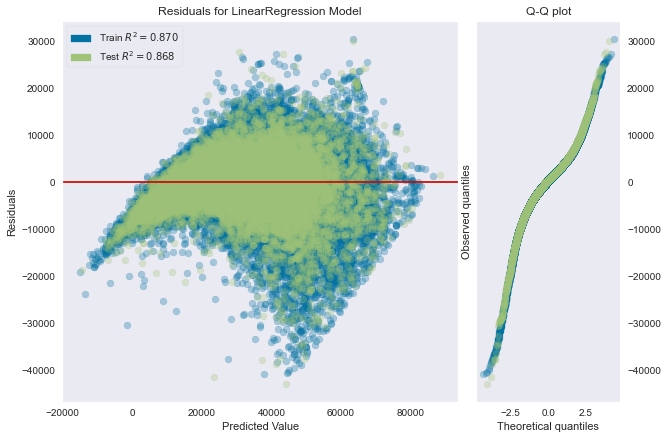

In [110]:



#Split again 8-2
X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

lm = LinearRegression()

plt.figure(figsize=(10,7))

res_plt = ResidualsPlot(lm, hist=False, qqplot=True, train_alpha=0.3, test_alpha=0.3, line_color='r')

res_plt.fit(X_train, y_train)  # Fit the training data to the visualizer
res_plt.score(X_test, y_test)  # Evaluate the model on the test data
plt.savefig('figures/residuals_linear.png')
res_plt.show();

In [52]:
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


RMSE:  3627.11

R-Squared:  0.92

Prediction Error Plot


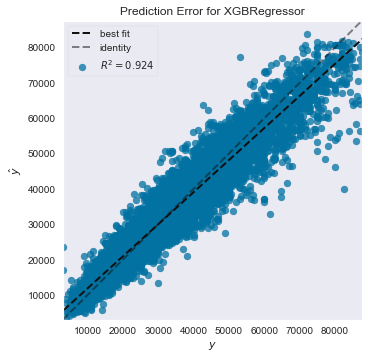

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=0,
                                       num_parallel_tree=1, random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                 

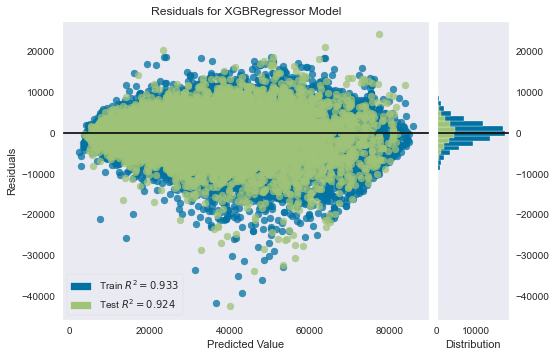

ResidualsPlot(ax=<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_we

<Figure size 576x396 with 0 Axes>

In [53]:
#Split again 8-2

X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test) # Predictions
y_true = y_test # True values

MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)

R_squared = r2_score(y_true, y_pred)

print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_reg, X_train, y_train, X_test, y_test))

# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(xgb_reg, X_train, y_train, X_test, y_test))

plt.savefig('figures/residuals_xgboost.png')

In [54]:
# X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# print("Random Forest Regression:", r2_score(y_test, y_pred))

# gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
# gbm.fit(X_train, y_train)
# y_pred = gbm.predict(X_test)
# print("Gradient Boosted Regression:", r2_score(y_test, y_pred))

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

# ## Scale the data as before
# std = StandardScaler()
# std.fit(X_train.values)

# ## Scale the Predictors on both the train and test set
# X_tr = std.transform(X_train.values)
# X_te = std.transform(X_test.values)

# # Run the cross validation, find the best alpha, refit the model on all the data with that alpha

# alphavec = 10**np.linspace(-2,2,200)

# lasso_model = LassoCV(alphas = alphavec, cv=5)
# lasso_model.fit(X_tr, y_train)

# #Best alpha = 0.24374441501222205
# lasso_model.fit(X_tr, y_train)
# lasso_model.alpha_

# # These are the (standardized) coefficients found
# # when it refit using that best alpha
# list(zip(X_train.columns, lasso_model.coef_))

# # Make predictions on the test set using the new model
# y_pred = lasso_model.predict(X_te)

# #Display some of the metrics:

# print('R^2 score on test set: {}'.format(r2_score(y_pred, y_test)))
# print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
# print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
# print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))

# ridge_model = RidgeCV(alphas = alphavec, cv=5)
# ridge_model.fit(X_tr, y_train)

# #Best alpha = 0.01
# ridge_model.fit(X_tr, y_train)
# ridge_model.alpha_

# # These are the (standardized) coefficients found
# # when it refit using that best alpha
# list(zip(X_train.columns, ridge_model.coef_))

# # Make predictions on the test set using the new model
# y_pred = ridge_model.predict(X_te)

# #Display some of the metrics:

# print('R^2 score on test set: {}'.format(r2_score(y_pred, y_test)))
# print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
# print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
# print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))

In [56]:
# #Create the model for streamlit

# model = LinearRegression()
# model.fit(pd.get_dummies(X_df, drop_first=True), y_df)
# joblib.dump(model, 'trained_lin_model.pkl')

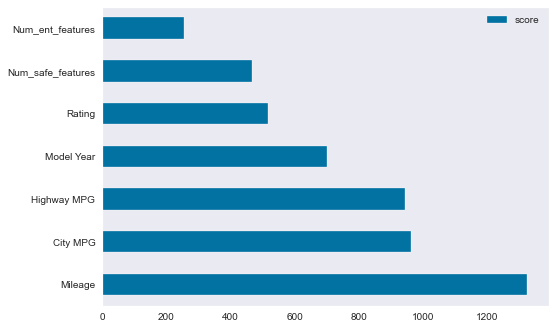

In [124]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh');